Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 20-June-2025

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

In [34]:
# Set source neurons
dict_ids = {}
dict_ids['DNg55'] = [14904]
dict_ids['DNge048'] = [11856, 12025]
dict_ids['DNge053'] = [13184, 13291]
dict_ids['DNp68'] = [14585, 15134]
dict_ids['DNpe053'] = [15016, 14999]
dict_ids['DNpe020'] = [20978, 21696, 22586, 26296]
dict_ids['DNp52'] = [151717]
dict_ids['DNpe042'] = [21069,190167]
dict_ids['DNge150'] = [12613, 13548]
dict_ids['DNge138'] = [16333, 154401, 16264, 17366]
dict_ids['DNd05'] = [13238, 12898]
dict_ids['DNge050'] = [10279, 11120]

source_ids = list(itertools.chain(*list(dict_ids.values())))

## Option 1: Query connectivity via neuprint

In [4]:
# ...

## Option 2: Load connectivity from disk

In [35]:
data_dir = r'E:/Code/Connectomics/Data/'
syn_thresh = 5

In [36]:
# Load connections
df_connectivity = pd.read_csv(data_dir+'connectome_connections_manc_v1.csv')

# Load classifications
df_class = pd.read_csv(data_dir+'connectome_classifications_manc_v1.csv')

# Rename columns for consistency with FlyWire dataset
df_connectivity = df_connectivity.rename(columns={"bodyId_pre": "pre_root_id", "bodyId_post": "post_root_id", "weight": "syn_count"}, errors="raise")

df_class = df_class.rename(columns={"bodyId": "root_id", 
                                    "class": "super_class", 
                                    "predictedNt": "nt_type",
                                    "predictedNtProb": "nt_type_score"}, 
                           errors="raise")

In [37]:
# Sum synapses across neuropils
df_connectivity = df_connectivity.groupby(['pre_root_id','post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

In [38]:
# Remove connections between neurons smaller than syn_thresh 
df_connectivity = df_connectivity[df_connectivity.syn_count>=syn_thresh]
df_connectivity

,pre_root_id,post_root_id,syn_count
451496,10725,10439,1080
319442,10480,11104,1072
98748,10146,10302,1001
246159,10352,13006,960
174356,10256,10220,946
...,...,...,...
4734929,100156,14540,5
2156532,15604,15633,5
3774457,24908,11503,5
62,10000,13361,5


In [39]:
# Trim connectivity dataframe
df_connectivity_post = df_connectivity[df_connectivity.pre_root_id.isin(source_ids)]

In [40]:
# Add information about postsynaptic neurons 
nt_type = []
super_class = []
sub_class = []

for index, row in df_connectivity_post.iterrows():
    nt_type_temp = df_class.nt_type[df_class.root_id==row.post_root_id].item()
    if pd.isnull(nt_type_temp):
        nt_type_temp = "unknown"
    nt_type.append(nt_type_temp)
    super_class_temp = df_class.super_class[df_class.root_id==row.post_root_id].item()
    if super_class_temp == 'efferent ascending':
        super_class_temp = 'efferent neuron'
    elif super_class_temp == 'sensory ascending':
        super_class_temp = 'sensory neuron'
    super_class.append(super_class_temp)
    sub_class.append(df_class.subclass[df_class.root_id==row.post_root_id].item())

df_connectivity_post['nt_type'] = nt_type
df_connectivity_post['super_class'] = super_class
df_connectivity_post['sub_class'] = sub_class

In [41]:
# Remove connections with glia
df_connectivity_post = df_connectivity_post[df_connectivity_post.super_class != 'Glia']
df_connectivity_post = df_connectivity_post.reset_index(drop=True)

In [42]:
df_connectivity_post

,pre_root_id,post_root_id,syn_count,nt_type,super_class,sub_class
0,11120,10630,246,gaba,intrinsic neuron,IR
1,15134,11393,224,glutamate,efferent neuron,EN
2,14585,11170,205,glutamate,efferent neuron,EN
3,12898,11074,201,gaba,intrinsic neuron,BI
4,10279,10342,198,gaba,intrinsic neuron,IR
...,...,...,...,...,...,...
4529,11856,11529,5,glutamate,motor neuron,ml
4530,11856,10745,5,glutamate,intrinsic neuron,CR
4531,11856,11152,5,gaba,intrinsic neuron,IR
4532,11856,10233,5,gaba,intrinsic neuron,IR


## Compute connectivity with super classes

In [122]:
# Initialize synapse dictionary
super_classes = df_connectivity_post.super_class.unique().tolist() 
dict_synapses = {}
for source_id in source_ids:
    dict_synapses[source_id] = {}
    for super_class in super_classes:
        dict_synapses[source_id][super_class] = 0

In [123]:
# Populate synapse dictionary
for source_id in source_ids:
    syn_count_total = df_connectivity.syn_count[df_connectivity.pre_root_id == source_id].sum().item()
    # Use original df_connectivity to get total synapse count

    for super_class in super_classes:
        syn_count = df_connectivity_post.syn_count[(df_connectivity_post.pre_root_id == source_id) & (df_connectivity_post.super_class == super_class)].sum().item()
        dict_synapses[source_id][super_class] += syn_count / syn_count_total

In [124]:
# Build connectivity matrix
connectivity_matrix = np.zeros((len(source_ids),len(super_classes)))
for source_index, source_id in enumerate(dict_synapses.keys()):
    for super_class_index, super_class in enumerate(super_classes):
        connectivity_matrix[source_index,super_class_index] = dict_synapses[source_id][super_class]

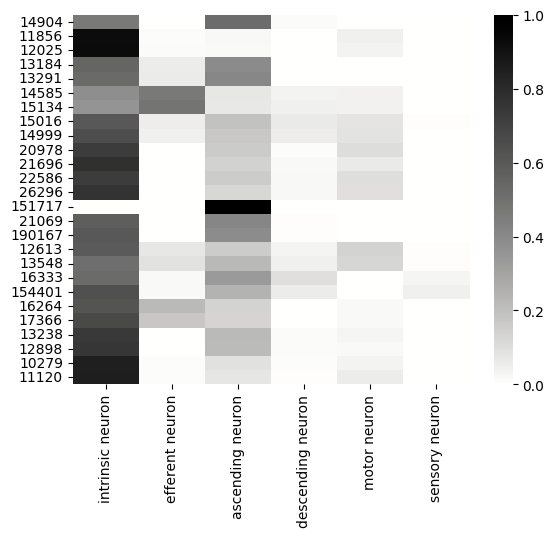

In [125]:
# Plot connectivity matrix
cmap = cmocean.cm.gray_r

sns.heatmap(connectivity_matrix,
            yticklabels = source_ids,
            xticklabels = super_classes,
            cmap = cmap)
plt.show()

In [126]:
# Average rows for the same source neuron type
neuron_names = list(dict_ids.keys())
connectivity_matrix_grouped = np.zeros((len(neuron_names),np.size(connectivity_matrix,axis=1)))
for key_index, key in enumerate(neuron_names):
    n_neurons = len(dict_ids[key])   
    if key_index == 0:
        start_index = 0
    else:
        start_index = end_index 
    end_index = start_index + n_neurons
    
    connectivity_matrix_grouped[key_index,:] = np.mean(connectivity_matrix[start_index:end_index,],axis=0)

connectivity_matrix = connectivity_matrix_grouped
del connectivity_matrix_grouped

In [127]:
# Sort connectivity matrix 
neuron_names = list(dict_ids.keys())

# Sort rows based on ... ipynb
sort_index = [5, 10, 1, 11, 4, 3, 8, 6, 7, 0, 2, 9]
connectivity_matrix = connectivity_matrix[[i for i in sort_index],:]
neuron_names = [neuron_names[i] for i in sort_index]

# Sort columns
sort_list = ['intrinsic neuron','motor neuron','ascending neuron','descending neuron','sensory neuron','efferent neuron']
sort_index = [super_classes.index(i) for i in sort_list]
connectivity_matrix = connectivity_matrix[:, [i for i in sort_index]]
super_classes = [super_classes[i] for i in sort_index]

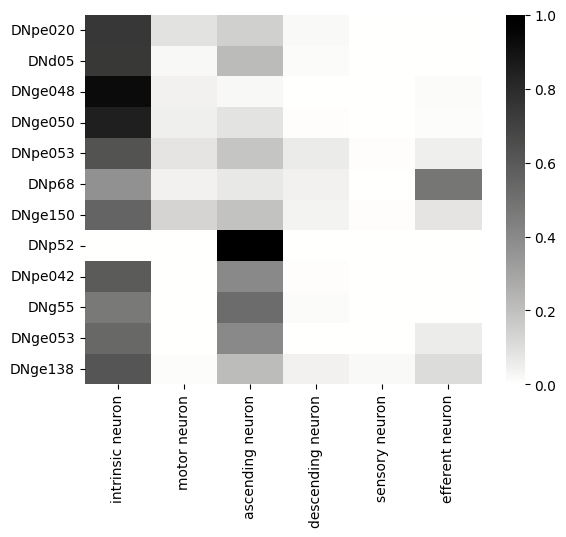

In [129]:
# Plot connectivity matrix
cmap = cmocean.cm.gray_r

sns.heatmap(connectivity_matrix,
            yticklabels = neuron_names,
            xticklabels = super_classes,
            cmap = cmap,
            vmax = 1)
#plt.savefig(r"C:\Users\Chris\Desktop\connectivity_matrix.eps", bbox_inches="tight", transparent=True)
plt.show()

## Compute connectivity with premotor neuron classes

In [154]:
# Build dictionary with premotor IDs
#
# To do: Add threshold for presynaptic neurons to qualify as premotor 
df_class_motor = df_class[df_class.super_class == 'motor neuron']
root_ids_intrinsic = df_class.root_id[df_class.super_class == 'intrinsic neuron'].tolist()

# Initialize dictionary
dict_premotor = {}
premotor_classes = ['fl_ml_hl', 'nm', 'wm', 'hm', 'ad', 'xm']
for premotor_class in premotor_classes:
    dict_premotor[premotor_class] = []

# Loop over motor neurons
root_ids = df_class_motor.root_id.tolist()
for root_id in root_ids:    
    sub_class = df_class.subclass[df_class.root_id == root_id].item()
    # Treat sub classes 'fl', 'ml', and 'hl' as one sub class
    if sub_class in ['fl','ml','hl']:
        sub_class = 'fl_ml_hl' 
    df_connectivity_pre = df_connectivity[df_connectivity.post_root_id == root_id]
    pre_root_ids = df_connectivity_pre.pre_root_id.unique().tolist()

    # Loop over presynaptic neurons
    for pre_root_id in pre_root_ids:
        if (pre_root_id in root_ids_intrinsic) & (pre_root_id not in dict_premotor[sub_class]):
            dict_premotor[sub_class].append(pre_root_id)

In [156]:
# Initialize synapse dictionary
dict_synapses = {}
for source_id in source_ids:
    dict_synapses[source_id] = {}
    for premotor_class in premotor_classes:
        dict_synapses[source_id][premotor_class] = 0

In [157]:
# Populate synapse dictionary
for source_id in source_ids:
    syn_count_total = df_connectivity.syn_count[df_connectivity.pre_root_id == source_id].sum().item()
    # Use original df_connectivity to get total synapse count
    
    #post_root_ids = df_connectivity_post.post_root_id[(df_connectivity_post.pre_root_id == source_id) & (df_connectivity_post.super_class == 'intrinsic neuron')].unique().tolist()
    post_root_ids = df_connectivity_post.post_root_id[df_connectivity_post.pre_root_id == source_id].unique().tolist()

    for post_root_id in post_root_ids:
        for premotor_class in premotor_classes:
            if post_root_id in dict_premotor[premotor_class]:
                syn_count = df_connectivity_post.syn_count[(df_connectivity_post.pre_root_id == source_id) & (df_connectivity_post.post_root_id == post_root_id)].item()
                dict_synapses[source_id][premotor_class] += syn_count / syn_count_total

In [159]:
# Build connectivity matrix
connectivity_matrix = np.zeros((len(source_ids),len(premotor_classes)))
for source_index, source_id in enumerate(dict_synapses.keys()):
    for premotor_index, premotor_class in enumerate(premotor_classes):
        connectivity_matrix[source_index,premotor_index] = dict_synapses[source_id][premotor_class]

In [160]:
# Average rows for the same source neuron type
neuron_names = list(dict_ids.keys())
connectivity_matrix_grouped = np.zeros((len(neuron_names),np.size(connectivity_matrix,axis=1)))
for key_index, key in enumerate(neuron_names):
    n_neurons = len(dict_ids[key])   
    if key_index == 0:
        start_index = 0
    else:
        start_index = end_index 
    end_index = start_index + n_neurons
    
    connectivity_matrix_grouped[key_index,:] = np.mean(connectivity_matrix[start_index:end_index,],axis=0)

connectivity_matrix = connectivity_matrix_grouped
del connectivity_matrix_grouped

In [161]:
# Sort connectivity matrix

# Sort rows based on ... ipynb
sort_index = [5, 10, 1, 11, 4, 3, 8, 6, 7, 0, 2, 9]
connectivity_matrix = connectivity_matrix[[i for i in sort_index],:]
neuron_names = [neuron_names[i] for i in sort_index]

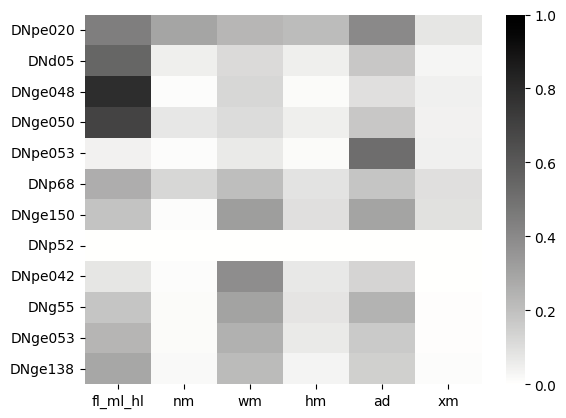

In [165]:
# Plot connectivity matrix
cmap = cmocean.cm.gray_r

sns.heatmap(connectivity_matrix,
            yticklabels = neuron_names,
            xticklabels = premotor_classes,
            cmap = cmap, 
            vmax = 1)
#plt.savefig(r"C:\Users\Chris\Desktop\connectivity_matrix.eps", bbox_inches="tight", transparent=True)
plt.show()

## Find top postsynaptic neurons of a descending neuron type

In [270]:
# Select specific neuron type
pre_root_ids = dict_ids['DNge138']

In [271]:
# Get postsynaptic connectivity
df_connectivity_post = df_connectivity[df_connectivity.pre_root_id.isin(pre_root_ids)]
df_connectivity_post = df_connectivity_post.groupby(['post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

In [272]:
# Add information about postsynaptic neurons
instance = []
super_class = []
nt_type = []

for index, row in df_connectivity_post.iterrows():
    root_id = row.post_root_id
    instance.append(df_class.instance[df_class.root_id==root_id].item())
    super_class.append(df_class.super_class[df_class.root_id==root_id].item())
    nt_type.append(df_class.nt_type[df_class.root_id==root_id].item())

df_connectivity_post["instance"] = instance
df_connectivity_post["super_class"] = super_class
df_connectivity_post["nt_type"] = nt_type
df_connectivity_post.head(10)

,post_root_id,syn_count,instance,super_class,nt_type
145,13395,148,TBD,efferent neuron,glutamate
126,12774,143,TBD,efferent neuron,unknown
43,10804,132,AN18B007_T3_L,ascending neuron,acetylcholine
137,13024,98,TBD,efferent neuron,glutamate
11,10182,97,AN19B001_T2_L,ascending neuron,acetylcholine
85,11745,91,TBD,efferent neuron,glutamate
34,10519,91,AN18B007_T3_R,ascending neuron,acetylcholine
247,20072,82,IN05B026_T2_L,intrinsic neuron,gaba
162,14002,75,IN06B027_T3_L,intrinsic neuron,gaba
91,11910,73,IN01A022_T1_R,intrinsic neuron,acetylcholine


In [ ]:
# # Compute connectivity matrix with postsynaptic partners 
#
# # Sort dataframe
# df_post = df_post.sort_values(by=["super_class","nt_type","syn_count"], ascending=[True, True, False])
# post_ids = df_post.post_root_id.unique().tolist()
# conn_mat = np.zeros((len(source_ids),len(post_ids)))
# 
# for index, row in df_post.iterrows():
#    source_id = row.pre_root_id
#    post_id = row.post_root_id
#    syn_count = row.syn_count 
#    conn_mat[source_ids.index(source_id), post_ids.index(post_id)] += syn_count   
#
# # Compute relative output
# conn_mat = conn_mat/conn_mat.sum(axis=1, keepdims=True)

In [ ]:
# # Plot connectivity matrix
# fig = plt.figure(figsize=(30,2))
# cmap = cmocean.cm.gray_r
#
# xticklabels = []
# for post_id in post_ids:
#     label = df_post.super_class[df_post.post_root_id == post_id].unique().item() + ' -- ' + df_post.nt_type[df_post.post_root_id == post_id].unique().item()
#     xticklabels.append(label)
# #xticklabels = list(itertools.chain(*xticklabels))
# 
# sns.heatmap(conn_mat,
#             yticklabels = source_ids,
#             xticklabels = xticklabels,
#             cmap = cmap,
#             vmax=0.05)
# plt.show()

In [ ]:
## Initialize synapse dictionary
#super_classes = df_post.super_class.unique().tolist() 
#dict_synapses = {}
#for source_id in source_ids:
#    dict_synapses[source_id] = {}
#    for super_class in super_classes:
#        dict_synapses[source_id][super_class] = 0
#        if 'intrinsic' in super_class:
#            dict_synapses[source_id]['intrinsic_gaba'] = 0
#            dict_synapses[source_id]['intrinsic_glutamate'] = 0
#            dict_synapses[source_id]['intrinsic_acetylcholine'] = 0
#            dict_synapses[source_id]['intrinsic_unknown'] = 0

In [ ]:
## Populate synapse dictionary
#for source_id in source_ids:
#    syn_count_total = df_post.syn_count[df_post.pre_root_id == source_id].sum().item()
#
#    for super_class in super_classes:
#        syn_count = df_post.syn_count[(df_post.pre_root_id == source_id) & (df_post.super_class == super_class)].sum().item()
#        dict_synapses[source_id][super_class] += syn_count / syn_count_total
#        if 'intrinsic' in super_class:
#            dict_synapses[source_id]['intrinsic_gaba'] += df_post.syn_count[(df_post.pre_root_id == source_id) & (df_post.super_class == super_class) & (df_post.nt_type == 'gaba')].sum().item() / syn_count_total
#            dict_synapses[source_id]['intrinsic_glutamate'] += df_post.syn_count[(df_post.pre_root_id == source_id) & (df_post.super_class == super_class) & (df_post.nt_type == 'glutamate')].sum().item() / syn_count_total
#            dict_synapses[source_id]['intrinsic_acetylcholine'] += df_post.syn_count[(df_post.pre_root_id == source_id) & (df_post.super_class == super_class) & (df_post.nt_type == 'acetylcholine')].sum().item() / syn_count_total
#            dict_synapses[source_id]['intrinsic_unknown'] += df_post.syn_count[(df_post.pre_root_id == source_id) & (df_post.super_class == super_class) & (df_post.nt_type == 'unknown')].sum().item() / syn_count_total

In [ ]:
## Build connectivity matrix
#super_classes_new = [
#    'intrinsic neuron',
#    'intrinsic_gaba',
#    'intrinsic_glutamate',
#    'intrinsic_acetylcholine',
#    'intrinsic_unknown',
#    'efferent neuron',
#    'efferent ascending',
#    'ascending neuron',
#    'descending neuron',
#    'motor neuron',
#    'Glia',
#    'sensory neuron',
#    'sensory ascending'
#]
#conn_mat = np.zeros((len(source_ids),len(super_classes_new)))
#for source_index, source_id in enumerate(dict_synapses.keys()):
#    for super_class_index, super_class in enumerate(super_classes_new):
#        conn_mat[source_index,super_class_index] = dict_synapses[source_id][super_class]